In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import os
import nc_time_axis
import matplotlib.pyplot as plt
#from geocat.viz import util as gvutil
import cartopy
import xesmf as xe
import xskillscore as xs
#cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
%matplotlib inline

from mypyutils import calendar_utils as cal
from mypyutils import stat_utils as stat
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import io_utils as io
from mypyutils import regrid_utils as regrid

In [2]:
def detrend_linear2(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:,:]

def detrend_linear_tg(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:]
    
def detrend_deseason_tg(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear_tg(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea  
    return fosi_desea.drop_vars('month'), fosi_trend
    
def detrend_deseason(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear2(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea
    return fosi_desea.drop_vars('month'), fosi_trend

In [3]:
import dask
from dask.distributed import wait
dask.__version__

'2023.7.0'

## Create Dask Cluster

In [61]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
client.shutdown()
!rm dask-worker*

In [9]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='30GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=30GB',
        account='UARH0002',
        walltime='02:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

In [10]:
cluster, client = get_ClusterClient()
cluster.scale(20) 

/glade/work/clittle/conda-envs/mypythonenv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34123 instead
  warnings.warn(


In [11]:
client

<Client: 'tcp://128.117.208.173:46381' processes=0 threads=0, memory=0 B>

In [21]:
ls /glade/work/yeager/datashare/ALPACA/

g.e21.GIAF_JRA_v1p5.TL319_g17.004.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_g17.B.001.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_g17.M.001.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_g17.RYF0304.003.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_t13.001.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_t13.B.001.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_t13.M.001.pop.h.000101_006612.SSH.nc
g.e21.GIAF_JRA_v1p5.TL319_t13.RYF0304.001.pop.h.000101_006612.SSH.nc


In [47]:
ylo=1400; yhi=1800; xlo=0; xhi=700; #HR2 EC SMALL

# ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.M.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
# ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.B.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
ds=ds.chunk(40, 100, 100)
da1=ds.SSH.isel(time=slice(792-31*12,792-12)).isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi)).load()

ds=xr.open_dataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_t13.RYF0304.001.pop.h.000101_006612.SSH.nc')#, parallel=True)
ds=ds.chunk(40, 100, 100)
da2=ds.SSH.isel(time=slice(792-31*12,792-12)).isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi)).load()
# ds=xr.open_mfdataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_g17.004.pop.h.000101_006612.SSH.nc')
# ds=xr.open_mfdataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_g17.B.001.pop.h.000101_006612.SSH.nc')
# ds=xr.open_mfdataset('/glade/work/yeager/datashare/ALPACA/g.e21.GIAF_JRA_v1p5.TL319_g17.M.001.pop.h.000101_006612.SSH.nc')
# ds = cal.time_set_midmonth(ds, "time") #LR
# # ds=ds.where(ds.SSH < 1e5)
# ds2 = cal.time_set_midmonth(ds2, "time") #LR
# ds2=ds2.where(ds2.SSH < 1e5)

In [53]:
da1, da2

(<xarray.DataArray 'SSH' (time: 360, nlat: 400, nlon: 700)>
 array([[[ 3.00165501e+01,  2.99426231e+01,  2.98797379e+01, ...,
           1.05457342e+00,  9.47659433e-01,  8.58492076e-01],
         [ 3.00897102e+01,  3.00448322e+01,  2.99712162e+01, ...,
           1.03560936e+00,  9.51458871e-01,  8.43934834e-01],
         [ 3.02076588e+01,  3.01793137e+01,  3.01507111e+01, ...,
           9.92267847e-01,  8.96703720e-01,  8.14083397e-01],
         ...,
         [            nan,             nan,             nan, ...,
          -1.09338097e+02, -1.09394852e+02, -1.09225685e+02],
         [            nan,             nan,             nan, ...,
          -1.09497063e+02, -1.09530762e+02, -1.09374718e+02],
         [            nan,             nan,             nan, ...,
          -1.09679199e+02, -1.09658554e+02, -1.09519997e+02]],
 
        [[ 3.03766136e+01,  2.99568424e+01,  2.92793980e+01, ...,
          -3.06029040e-02, -2.07214996e-01, -4.41116631e-01],
         [ 3.05180721e+01, 

In [54]:
# da=ds.SSH#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))
# da1=ds.SSH#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))
# da2=ds.SSH#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))
# ylo=1200; yhi=2200; xlo=100; xhi=1000; #HR2 EC SMALL
# xlo=260; xhi=320; ylo=250; yhi=350;
da=da1-da2
# da=da.isel(time=slice(792-31*12,792-12))#.isel(nlon=slice(xlo,xhi),nlat=slice(ylo,yhi))

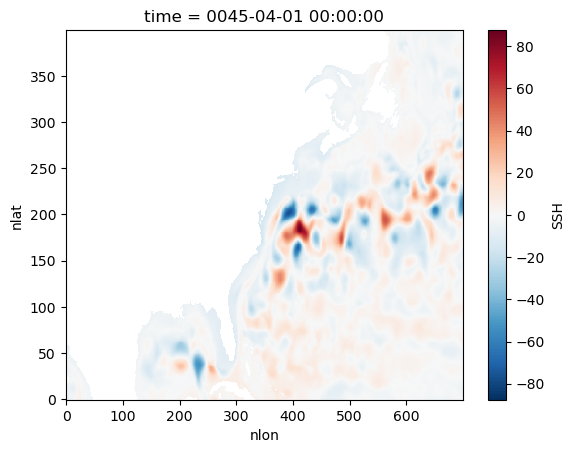

In [55]:
(da[110,:,:]).plot()

In [56]:
da.load()

<xarray.DataArray 'SSH' (time: 360, nlat: 400, nlon: 700)>
array([[[ 4.3629837 ,  4.152584  ,  4.031521  , ...,  1.4268601 ,
          1.4859169 ,  1.5815916 ],
        [ 4.6829605 ,  4.4509144 ,  4.3120556 , ...,  1.4176705 ,
          1.5115035 ,  1.5465815 ],
        [ 4.9403763 ,  4.724962  ,  4.604824  , ...,  1.3591074 ,
          1.4031978 ,  1.4879194 ],
        ...,
        [        nan,         nan,         nan, ..., -6.965782  ,
         -6.944275  , -6.793724  ],
        [        nan,         nan,         nan, ..., -7.002617  ,
         -6.998802  , -6.8107834 ],
        [        nan,         nan,         nan, ..., -7.0056305 ,
         -6.91848   , -6.804535  ]],

       [[ 5.497429  ,  4.919298  ,  4.1502438 , ...,  3.3474112 ,
          3.2676218 ,  3.1090314 ],
        [ 6.432104  ,  5.7996216 ,  5.0128193 , ...,  3.3169858 ,
          3.1919007 ,  3.1061678 ],
        [ 7.0858116 ,  6.5059605 ,  5.6197567 , ...,  3.0482297 ,
          2.9911656 ,  2.8655534 ],
...
        [        nan,         nan,         nan, ..., -5.4656525 ,
         -5.599701  , -5.667038  ],
        [        nan,         nan,         nan, ..., -6.060852  ,
         -6.236801  , -6.26326   ],
        [        nan,         nan,         nan, ..., -6.411331  ,
         -6.5335693 , -6.6313095 ]],

       [[-1.0151043 , -1.4510708 , -1.7275352 , ...,  3.2388253 ,
          3.1058173 ,  2.959804  ],
        [-0.53694725, -0.96917534, -1.3053799 , ...,  3.1550276 ,
          3.0355225 ,  2.8925307 ],
        [-0.35473442, -0.77882576, -1.0759945 , ...,  3.0580142 ,
          2.9413111 ,  2.813148  ],
        ...,
        [        nan,         nan,         nan, ..., -5.3018875 ,
         -5.527771  , -5.656288  ],
        [        nan,         nan,         nan, ..., -5.85067   ,
         -5.969223  , -5.971695  ],
        [        nan,         nan,         nan, ..., -6.331047  ,
         -6.33049   , -6.2111816 ]]], dtype=float32)
Coordinates:
    TLAT     (nlat, nlon) float64 21.34 21.34 21.34 21.34 ... 55.26 55.27 55.27
    TLONG    (nlat, nlon) float64 250.0 250.2 250.2 250.3 ... 317.5 317.6 317.7
  * time     (time) object 0036-02-01 00:00:00 ... 0066-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [57]:
[hrdesea, hrtrend]=detrend_deseason(da)

In [46]:
import momlevel
import pandas as pd
tgcsvin="./tgs_in_93_22.csv" #need to read in from csv for momlevel
tgs_in=pd.read_pickle("./tgs_in_93_22.pkl")
omask=xr.where(np.isnan(da[0,:,:]), 0, 1)
tgs_hr_xr=momlevel.extract_tidegauge(hrdesea, da.TLONG, da.TLAT, mask=omask, csv=tgcsvin)
tgs_hr_xr=tgs_hr_xr.to_array("tgindex", name="ssh").to_dataset().assign_coords(
    tgindex=tgs_in.name.to_list()
)


In [47]:
# !rm /glade/derecho/scratch/clittle/alpaca_hr_ssh_m-r_tgs.nc
tgs_hr_xr.to_netcdf('/glade/derecho/scratch/clittle/alpaca_hr_ssh_m-r_tgs.nc',mode='w')

In [60]:
# !rm /glade/derecho/scratch/clittle/big_alpaca_hr_ssh_m-r.nc
# hrdesea
# # hrdesea.to_netcdf('/glade/derecho/scratch/clittle/LRSSH1920_2005_10mem_1deg.nc',mode='w')
hrdesea=hrdesea.to_dataset(name='ssh')
hrdesea.to_netcdf('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_m-r.nc',mode='w')